In [10]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from c3.libraries import fidelities
from c3.parametermap import ParameterMap
from utils import *
from c3.experiment import Experiment
import c3.libraries.constants as constants
import c3.utils.qt_utils as qt_utils

In [11]:
# plotting functions
def plotOccupations(
        experiment: Experiment,
        populations: np.array,
        gate_sequence: List[str],
        level_names: List[str] = None,
        filename: str = None,
) -> None:
    """
    Plots time dependent populations. They need to be calculated with `runTimeEvolution` first.

    Parameters
    ----------
    experiment: Experiment
        The experiment containing the model and propagators
    populations: np.array
        Population vector for each time step
    gate_sequence: List[str]
        List of gate names that will be applied to the state
    level_names: List[str]
        Optional list of names for the levels. If none, the default list
        from the experiment will be used.
    filename: str
        Optional name of the file to which the plot will be saved. If none,
        it will only be shown.

    Returns
    -------

    """
    # plot populations
    fig, axs = plt.subplots(1, 1)
    dt = experiment.ts[1] - experiment.ts[0]
    ts = np.linspace(0.0, dt * populations.shape[1], populations.shape[1])
    axs.plot(ts / 1e-9, populations.T)

    # plot vertical lines
    gate_steps = [experiment.partial_propagators[g].shape[0] for g in gate_sequence]
    for i in range(1, len(gate_steps)):
        gate_steps[i] += gate_steps[i - 1]
    gate_times = gate_steps * dt
    plt.vlines(gate_times / 1e-9, tf.reduce_min(populations), tf.reduce_max(populations),
               linestyles=':', colors="black")

    # set plot properties
    axs.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
    axs.set_xlabel('Time [ns]')
    axs.set_ylabel('Population')
    plt.legend(level_names if level_names else experiment.pmap.model.state_labels)
    plt.tight_layout()

    # show and save
    if filename:
        print("saving plot in " + filename)
        plt.savefig(filename)
    else:
        plt.show()
    plt.close()


def plotSignal(time, signal, filename=None, spectrum_cut=1e-4) -> None:
    """
    Plots a time dependent signal and its normalised frequency spectrum.

    Parameters
    ----------
    time
        timestamps
    signal
        signal value
    filename: str
        Optional name of the file to which the plot will be saved. If none,
        it will only be shown.
    spectrum_cut:
        If not None, only the part of the normalised spectrum will be plotted
        whose absolute square is larger than this value.

    Returns
    -------

    """
    # plot time domain
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].set_title('Signal')
    axs[0].plot(time, signal)
    axs[0].set_xlabel('time')

    # calculate frequency spectrum
    n_samples = time.shape[-1]
    freq_signal = np.fft.rfft(signal)
    normalised = freq_signal / np.max(freq_signal)
    freq = np.fft.rfftfreq(n_samples, time[-1] / n_samples)
    print("fft: ", n_samples, len(freq), len(normalised))

    # cut spectrum if necessary
    if spectrum_cut is not None:
        limits = np.flatnonzero(np.abs(normalised) ** 2 > 1e-4)
        freq = freq[limits[0]:limits[-1]]
        normalised = normalised[limits[0]:limits[-1]]

    # plot frequency domain
    axs[1].set_title('Spectrum')
    axs[1].plot(freq, normalised.real, label="Re")
    axs[1].plot(freq, normalised.imag, label="Im")
    axs[1].plot(freq, np.abs(normalised) ** 2, label="Square")
    axs[1].set_xlabel('frequency')
    axs[1].legend()

    # show and save
    plt.tight_layout()
    if filename:
        print("saving plot in " + filename)
        plt.savefig(filename)
    else:
        plt.show()
    plt.close()

4 1.75e-09
saving plot in ./output/populations_4.png
fft:  10000 5001 5001
saving plot in ./output/envelope_4.png
fft:  700 351 351
saving plot in ./output/signal_4.png
9 7.777777777777777e-10
saving plot in ./output/populations_9.png
fft:  10000 5001 5001
saving plot in ./output/envelope_9.png
fft:  700 351 351
saving plot in ./output/signal_9.png
14 5e-10
saving plot in ./output/populations_14.png
fft:  10000 5001 5001
saving plot in ./output/envelope_14.png
fft:  700 351 351
saving plot in ./output/signal_14.png
19 3.6842105263157894e-10
saving plot in ./output/populations_19.png
fft:  10000 5001 5001
saving plot in ./output/envelope_19.png
fft:  700 351 351
saving plot in ./output/signal_19.png
24 2.9166666666666664e-10
saving plot in ./output/populations_24.png
fft:  10000 5001 5001
saving plot in ./output/envelope_24.png
fft:  700 351 351
saving plot in ./output/signal_24.png
29 2.413793103448276e-10
saving plot in ./output/populations_29.png
fft:  10000 5001 5001
saving plot in 

KeyboardInterrupt: 

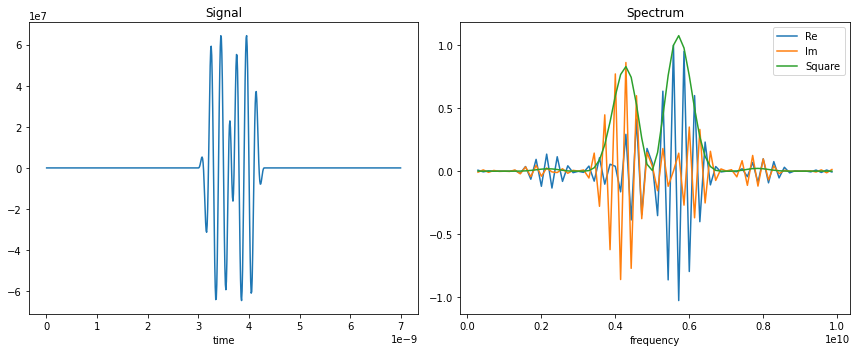

In [12]:
def createPulse(t_final: float, sigma_factor: float) -> None:
    # preparation
    occupied_levels = [0, 2]
    directory = "./output"
    output_dir = pathlib.Path(directory)
    output_dir.mkdir(parents=True, exist_ok=True)

    # model
    q1 = createQubit(1, 5, 5e9, -300e6)
    model = createModel([q1])
    generator = createGenerator(model)

    # gate
    envelope = createGaussianPulse(t_final, t_final / sigma_factor)
    ideal = qt_utils.np_kron_n([
        constants.Id,
        constants.x90p,
    ])
    #print('ideal gate:\n', np.round(ideal, 3))
    gate = createSingleQubitGate("lower-X", t_final, 5e9, envelope, model, q1, ideal)
    gates = [gate]
    gate_names = list(map(lambda g: g.get_key(), gates))

    # experiment
    exp = Experiment(pmap=ParameterMap(instructions=gates, model=model, generator=generator))
    exp.set_opt_gates(gate_names)
    exp.compute_propagators()

    # initial state
    init_state = createState(model, occupied_levels)
    #state = init_state.numpy().flatten()
    #print("initial state=", state, ", occupation=", exp.populations(state, model.lindbladian).numpy())

    # time evolution and signal before optimisation
    sequence = ["lower-X[0]"]
    populations = runTimeEvolutionDefault(exp, init_state, sequence)
    plotOccupations(exp, populations, sequence, filename=directory + f"/populations_{sigma_factor}.png")
    signal = generator.generate_signals(gate)[getDrive(model, q1).name]
    ts = np.linspace(0, t_final, 10000)
    plotSignal(ts, envelope.get_shape_values(ts), directory + f"/envelope_{sigma_factor}.png")
    plotSignal(signal['ts'], signal['values'], directory + f"/signal_{sigma_factor}.png", spectrum_cut=1e-4)


def runExperiment() -> None:
    # preparation
    active_levels = 4
    occupied_levels = [0, 2]
    directory = "./output"
    output_dir = pathlib.Path(directory)
    output_dir.mkdir(parents=True, exist_ok=True)

    # model
    q1 = createQubit(1, 4, 5e9, -300e6)
    model = createModel([q1])
    generator = createGenerator(model)

    # gate
    t_final = 7e-9
    envelope = createGaussianPulse(t_final, t_final / 4)
    ideal = qt_utils.np_kron_n([
        constants.Id,
        constants.x90p,
    ])
    print('ideal gate:\n', np.round(ideal, 3))
    gate = createSingleQubitGate("lower-X", t_final, 5e9, envelope, model, q1, ideal)
    gates = [gate]
    gate_names = list(map(lambda g: g.get_key(), gates))

    # experiment
    exp = Experiment(pmap=ParameterMap(instructions=gates, model=model, generator=generator))
    exp.set_opt_gates(gate_names)
    unitaries = exp.compute_propagators()
    #print('unitaries: ', dict(map(lambda kv: (kv[0], kv[1].numpy().shape), unitaries.items())))

    # initial state
    init_state = createState(model, occupied_levels)
    state = init_state.numpy().flatten()
    print("initial state=", state, ", occupation=", exp.populations(state, model.lindbladian).numpy())

    # time evolution and signal before optimisation
    sequence = ["lower-X[0]"] * 3
    populations = runTimeEvolutionDefault(exp, init_state, sequence)
    plotOccupations(exp, populations, sequence, filename=directory + "/populations_before.png")
    signal = generator.generate_signals(gate)[getDrive(model, q1).name]
    plotSignal(signal['ts'], signal['values'], directory + "/signal_before.png", spectrum_cut=1e-4)

    # add all optimisable parameters to a map
    drives = filterValues(model.couplings, chip.Drive)
    gateset_opt_map = []
    for gate in gates:
        for target in gate.targets:
            # TODO: target as index might not always work
            drive = drives[target]
            gateset_opt_map.append([(gate.get_key(), drive.name, "gauss", "amp")])
            gateset_opt_map.append([(gate.get_key(), drive.name, "gauss", "freq_offset")])
            gateset_opt_map.append([(gate.get_key(), drive.name, "gauss", "xy_angle")])
            gateset_opt_map.append([(gate.get_key(), drive.name, "gauss", "delta")])
            gateset_opt_map.append([(gate.get_key(), drive.name, "carrier", "framechange")])

    # optimise
    optimisable_gates = list(filter(lambda g: g.get_key() != "id[]", gates))
    callback = lambda fidelity: print(fidelity)
    params_before, final_fidelity, params_after = optimise(
        exp, optimisable_gates,
        optimisable_parameters=gateset_opt_map,
        fidelity_fctn=fidelities.state_transfer_infid_set,
        fidelity_params={
            'psi_0': init_state[:active_levels],
            'active_levels': 4,
        },
        callback=callback,
        log_dir=(directory + ("/log_{0:.2f}/".format(t_final * 1e9)))
    )
    print('before:\n', params_before)
    print('after:\n', params_after)
    print('fidelity:\n', final_fidelity)

    # time evolution and signal after optimisation
    populations = runTimeEvolutionDefault(exp, init_state, sequence)
    plotOccupations(exp, populations, sequence, filename=directory + "/populations_after.png")
    signal = generator.generate_signals(gate)[getDrive(model, q1).name]
    plotSignal(signal['ts'], signal['values'], directory + "/signal_after.png", spectrum_cut=1e-4)


t_final = 7e-9
sigma_factors = np.arange(4, 200, 5)
for sigma_factor in sigma_factors:
    print(sigma_factor, t_final / sigma_factor)
    createPulse(t_final, sigma_factor)